# Imports

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torcheval.metrics import MulticlassAccuracy
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Check if CUDA (GPU) is available and set the device accordingly.
device = "cuda" if torch.cuda.is_available() else "cpu"
device = 'cpu'
print(f"Using device: {device}")

Using device: cpu


# Data Loading

In [11]:
# Set up the label encoder for consistency in target labels
le = LabelEncoder()
labels = ['Benign', 'DDoS', 'Reconnaissance', 'injection', 'DoS', 'Brute Force', 'password', 'xss', 'Infilteration', 'Exploits', 'scanning', 'Fuzzers', 'Backdoor', 'Bot', 'Generic', 'Analysis', 'Theft', 'Shellcode', 'mitm', 'Worms', 'ransomware']
le.fit(labels)

LabelEncoder()

In [12]:
class NFUQNIDS(Dataset):
    def __init__(self, data_file):
        self.data = pd.read_csv(data_file)

        # Attack type as target label
        self.labels = self.data['Attack']
        self.labels = le.transform(self.labels)

        self.data.drop('Attack', axis=1, inplace=True)
        self.data.drop('Label', axis=1, inplace=True, errors='ignore')

        self.data = self.data.values

        print(self.data)
        print(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        features = torch.tensor(self.data[idx], dtype=torch.float32, device=device)
        label = torch.tensor(self.labels[idx], dtype=torch.float32, device=device)
        label = label.type(torch.LongTensor).to(device)

        return features, label

In [13]:
# Real data
# real_dataset = NFUQNIDS('data/cleaned/NF-UQ-NIDS-CLEANED.csv')
# benign_data = NFUQNIDS('data/cleaned/NF-UQ-NIDS-BENIGN.csv')
real_attack_data = NFUQNIDS('data/cleaned/NF-UQ-NIDS-ATTACKS.csv')

# Synthetic attack data
synthetic_attack_data = NFUQNIDS('data/synthetic/NF-UQ-NIDS-ATTACKS-SYNTHETIC.csv')

[[4.3025e+04 2.5000e+01 6.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [6.4923e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [9.0220e+03 1.1100e+02 6.0000e+00 ... 1.0000e+00 0.0000e+00 1.0000e+00]
 ...
 [0.0000e+00 0.0000e+00 8.7000e+01 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [0.0000e+00 0.0000e+00 8.7000e+01 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [4.4661e+04 8.0000e+01 6.0000e+00 ... 1.0000e+00 1.0000e+00 1.0000e+00]]
[ 7  7 11 ...  7  9  8]
[[0.0000e+00 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [0.0000e+00 1.1100e+02 6.0000e+00 ... 1.0000e+00 0.0000e+00 1.0000e+00]
 [0.0000e+00 0.0000e+00 6.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 ...
 [1.0430e+03 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [6.5312e+04 5.2000e+02 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 [8.5670e+03 2.5000e+01 1.7000e+01 ... 0.0000e+00 1.0000e+00 1.0000e+00]]
[8 9 8 ... 0 6 7]


In [14]:
batch_size = 4096
real_dataloader = DataLoader(real_attack_data, batch_size=batch_size, shuffle=True)
synthetic_dataloader = DataLoader(synthetic_attack_data, batch_size=batch_size, shuffle=True)

# Model Definition

In [15]:
# Model hyperparameters
input_dim = 74
hidden_dim = input_dim*2
num_classes = 21

# Model definition
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Model Training

In [21]:
# Model instantiation
model = Classifier(input_dim, hidden_dim, num_classes).to(device)

# Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

# Lists to store the loss values for training and validation sets
train_loss_list = []
test_loss_list = []

torch.set_float32_matmul_precision("medium")

for epoch in tqdm(range(num_epochs)):
    cumulative_loss = 0

    for inputs, labels in synthetic_dataloader:
        # Calculate training output and loss
        train_outputs = model(inputs)
        train_loss = criterion(train_outputs, labels)

        cumulative_loss = cumulative_loss + train_loss

        # epoch_train_loss = epoch_train_loss + train_loss.item()

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
    # Calculate training loss this epoch
    # train_loss_list.append(epoch_train_loss / len(synthetic_attack_data))
    cumulative_loss = cumulative_loss.item() / (len(synthetic_attack_data) / batch_size)
    train_loss_list.append(cumulative_loss)

    if(((epoch+1) % 10) == 0):
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {(cumulative_loss):.4f}')

 12%|█▏        | 12/100 [00:00<00:02, 31.21it/s]

Epoch [10/100], Train Loss: 294.4797


 24%|██▍       | 24/100 [00:00<00:02, 31.34it/s]

Epoch [20/100], Train Loss: 157.4906


 32%|███▏      | 32/100 [00:01<00:02, 31.51it/s]

Epoch [30/100], Train Loss: 128.6674


 44%|████▍     | 44/100 [00:01<00:01, 28.00it/s]

Epoch [40/100], Train Loss: 80.2322


 52%|█████▏    | 52/100 [00:01<00:01, 29.85it/s]

Epoch [50/100], Train Loss: 62.4402


 64%|██████▍   | 64/100 [00:02<00:01, 30.99it/s]

Epoch [60/100], Train Loss: 45.4600


 72%|███████▏  | 72/100 [00:02<00:00, 30.73it/s]

Epoch [70/100], Train Loss: 48.6312


 84%|████████▍ | 84/100 [00:02<00:00, 31.62it/s]

Epoch [80/100], Train Loss: 55.6687


 92%|█████████▏| 92/100 [00:02<00:00, 31.67it/s]

Epoch [90/100], Train Loss: 46.7545


100%|██████████| 100/100 [00:03<00:00, 30.72it/s]

Epoch [100/100], Train Loss: 41.2234


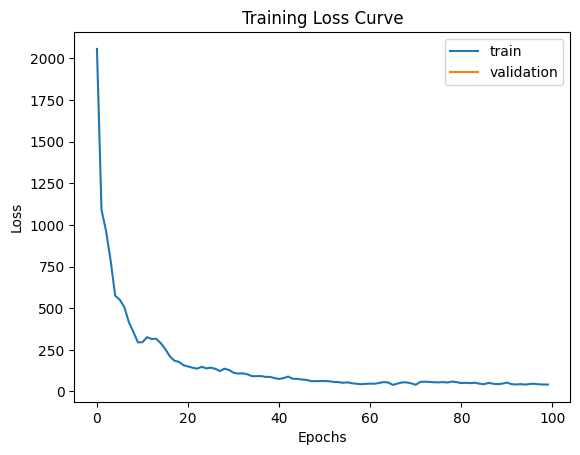

In [22]:
# Plot the loss curve
plt.plot(train_loss_list, label="train")
plt.plot(test_loss_list, label="validation")
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Model Evaluation

In [23]:
# Evaluation
model.eval()
with torch.no_grad():
    metric = MulticlassAccuracy(num_classes=num_classes)
    accuracy = 0
    num = 0

    for inputs, labels in real_dataloader:
        test_outputs = model(inputs)

        _, predicted = torch.max(test_outputs, 1)
        
        metric.update(predicted, labels)
        accuracy = accuracy + metric.compute()
        num = num + 1

    accuracy = accuracy / num
    print(accuracy)

tensor(0.2067)
